# Cardano Price Trend Prediction

In [1]:
# import of libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [3]:
#Metric Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [4]:
import warnings
warnings.filterwarnings("ignore")

**The dataset was extracted from investing.com**

The datasets were downloaded from www.investing.com and it contains the following features:

 - **Date:**	Daily date of the crypto information
 - **Price:**	USD prices of the crypto currency
 - **Open:**	Opening price of crypto currency (USD)
 - **High:**	Highest price of crypto currency (USD)
 - **Low:** 	Lowest price of crypto currency (USD)
 - **Vol.:**	Volume of crypto traded on the given date
 - **Change%:**	Percentage of the change in crypto currency prices relative to the previous day

In [5]:
cardano_hist = pd.read_csv('data/Cardano Historical Data.csv')

#columns to lower case
cardano_hist.columns = cardano_hist.columns.str.lower()

In [6]:
#Check  rows and columns
cardano_hist.head(5)

,date,price,open,high,low,vol.,change %
0,"Sep 30, 2021",2.1164,2.0655,2.1349,2.0515,250.07M,2.45
1,"Sep 29, 2021",2.0658,2.0370,2.1424,2.0220,272.69M,1.43
2,"Sep 28, 2021",2.0367,2.1312,2.1716,2.0300,289.31M,-4.41
3,"Sep 27, 2021",2.1307,2.2090,2.2726,2.1293,288.51M,-3.52
4,"Sep 26, 2021",2.2084,2.2985,2.2999,2.1490,452.94M,-3.92


In [7]:
cardano_hist.dtypes

date         object
price        object
open         object
high         object
low          object
vol.         object
change %    float64
dtype: object

In [8]:
print(cardano_hist.shape)

(1372, 7)


In [9]:
# Check for Nan values
cardano_hist.isna().sum()

date        2
price       1
open        1
high        1
low         1
vol.        1
change %    2
dtype: int64

* Out of 1372 rows, a few has nan values, later we will take a closer look to correct this values
* Most of the features were imported as a string value, an some of them have charaters that need to be transformed

## Data Cleansing

In [10]:
cardano_hist[cardano_hist["date"].isna()]

,date,price,open,high,low,vol.,change %
1370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1371,NaN,Highest:3.0989,Lowest:0.0178,Difference:3.0812,Average:0.3722,Change %:258.7039,NaN


In [11]:
cardano_hist.tail(5)

,date,price,open,high,low,vol.,change %
1367,"Jan 02, 2018",0.7620,0.7022,0.8000,0.6750,10.97M,8.52
1368,"Jan 01, 2018",0.7022,0.7100,0.7150,0.6320,17.95M,-1.10
1369,"Dec 31, 2017",0.7100,0.5900,0.7400,0.5900,17.22M,20.34
1370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1371,NaN,Highest:3.0989,Lowest:0.0178,Difference:3.0812,Average:0.3722,Change %:258.7039,NaN


The missing values correspond to thw last two rows.
* the first one has all missing values so we should delet this row
* the second one contains descriptive values that don't bellow to the information of the dataframe, so we should also drop this information 

In [12]:
# drop last two rows
cardano_hist = cardano_hist[:1370]

In [13]:
#change data type
for x in ['price','open','high','low']:
    cardano_hist[x] = cardano_hist[x].astype(float)

In [14]:
#change column name to make it more clear
cardano_hist = cardano_hist.rename(columns = {'change %':'change','vol.':'vol' })

In [15]:
#convert Date to datatime and create year, month and day column
cardano_hist.date = pd.to_datetime(cardano_hist.date)
cardano_hist[['year','month','day']] = cardano_hist.date.apply(lambda x: pd.Series(x.strftime("%Y-%m-%d").split("-")))
cardano_hist["month"] = cardano_hist["month"].astype(float)
cardano_hist["day"] = cardano_hist["day"].astype(float)

In [16]:

#delete % from string and transform to float
cardano_hist['change'] = cardano_hist.change.replace('%', '').astype(float)/100

**This fuction were inspired based on the open code from Kaggle: https://www.kaggle.com/jkreyner/script-to-clean-data-set**

In [17]:

def to_float(x):
    """
        Reformat column to numeric  
    Args: 
        x: Series of Vol to be transformed
    """    
    # transform to numeric base on the string value
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return

In [18]:
#transform data type to float
cardano_hist['vol'] = cardano_hist['vol'].apply(to_float)

In [19]:
# lets check for nan values after this transformations
print(cardano_hist.isna().sum())
cardano_hist[cardano_hist["vol"].isna()]

date      0
price     0
open      0
high      0
low       0
vol       5
change    0
year      0
month     0
day       0
dtype: int64


,date,price,open,high,low,vol,change,year,month,day
10,2021-09-20,2.0684,2.2827,2.2884,1.9827,NaN,-0.0939,2021,9.0,20.0
35,2021-08-26,2.5347,2.7402,2.7846,2.4701,NaN,-0.0750,2021,8.0,26.0
58,2021-08-03,1.3648,1.3086,1.3822,1.2626,NaN,0.0429,2021,8.0,3.0
80,2021-07-12,1.3147,1.3479,1.3731,1.2922,NaN,-0.0246,2021,7.0,12.0
259,2021-01-14,0.3110,0.3127,0.3241,0.2986,NaN,-0.0055,2021,1.0,14.0


This transformation creates some nan values, and checking in the original dataset it correspond to rows were the value were 0. That is, we had no information about the volumen traded this days, we could replace this nan with the volume of the previous day

In [20]:
cardano_hist.fillna(method='bfill', inplace = True)

In [21]:
print(cardano_hist.isna().sum())

date      0
price     0
open      0
high      0
low       0
vol       0
change    0
year      0
month     0
day       0
dtype: int64


In [22]:
#check that the nan was correctly remplaced
cardano_hist.iloc[8:12]

,date,price,open,high,low,vol,change,year,month,day
8,2021-09-22,2.2591,1.9842,2.2659,1.9691,564970000.0,0.1392,2021,9.0,22.0
9,2021-09-21,1.9830,2.0684,2.2239,1.9132,795400000.0,-0.0413,2021,9.0,21.0
10,2021-09-20,2.0684,2.2827,2.2884,1.9827,222620000.0,-0.0939,2021,9.0,20.0
11,2021-09-19,2.2827,2.3719,2.3959,2.2612,222620000.0,-0.0376,2021,9.0,19.0


In [23]:
cardano_hist.describe()

,price,open,high,low,vol,change,month,day
count,1370.000000,1370.000000,1370.000000,1370.000000,1.370000e+03,1370.000000,1370.000000,1370.000000
mean,0.372239,0.371315,0.390555,0.350343,4.592991e+08,0.002984,6.226277,15.733577
std,0.600406,0.598689,0.629400,0.566161,4.663479e+08,0.064444,3.351771,8.806074
min,0.023200,0.023200,0.026500,0.017800,4.810000e+06,-0.414900,1.000000,1.000000
25%,0.049800,0.049800,0.051700,0.048025,1.501675e+08,-0.030175,3.000000,8.000000
50%,0.093750,0.093750,0.097950,0.090600,3.282400e+08,0.000000,6.000000,16.000000
75%,0.296425,0.296425,0.313475,0.279025,5.962575e+08,0.030700,9.000000,23.000000
max,2.965200,2.965300,3.098900,2.903000,3.070000e+09,0.417300,12.000000,31.000000


###  Target variable 

The target variables is not a feature included in our data set, so we need to create it.

Considering that our main objetive is predict the price tend for the next day our target is %change of the next day transformed to a binary variable where:
* 1: the prices increased the next day 
* 0: the prices decreased the next day (No price change is considered 0)

In [24]:
cardano_hist['future_increase'] = np.where(cardano_hist.change.shift(1).fillna(value=0) > 0,1,0)

In [25]:
cardano_hist.head(10)

,date,price,open,high,low,vol,change,year,month,day,future_increase
0,2021-09-30,2.1164,2.0655,2.1349,2.0515,250070000.0,0.0245,2021,9.0,30.0,0
1,2021-09-29,2.0658,2.0370,2.1424,2.0220,272690000.0,0.0143,2021,9.0,29.0,1
2,2021-09-28,2.0367,2.1312,2.1716,2.0300,289310000.0,-0.0441,2021,9.0,28.0,1
3,2021-09-27,2.1307,2.2090,2.2726,2.1293,288510000.0,-0.0352,2021,9.0,27.0,0
4,2021-09-26,2.2084,2.2985,2.2999,2.1490,452940000.0,-0.0392,2021,9.0,26.0,0
5,2021-09-25,2.2985,2.2780,2.4553,2.2395,649940000.0,0.0090,2021,9.0,25.0,0
6,2021-09-24,2.2780,2.3277,2.3436,2.0700,656060000.0,-0.0213,2021,9.0,24.0,1
7,2021-09-23,2.3277,2.2577,2.3442,2.1808,355130000.0,0.0303,2021,9.0,23.0,0
8,2021-09-22,2.2591,1.9842,2.2659,1.9691,564970000.0,0.1392,2021,9.0,22.0,1
9,2021-09-21,1.9830,2.0684,2.2239,1.9132,795400000.0,-0.0413,2021,9.0,21.0,1


All features are ok, we are ready to explore the dataset

## Data Exploration

### Historical Price

First let's take a look at the cardano historical prices.

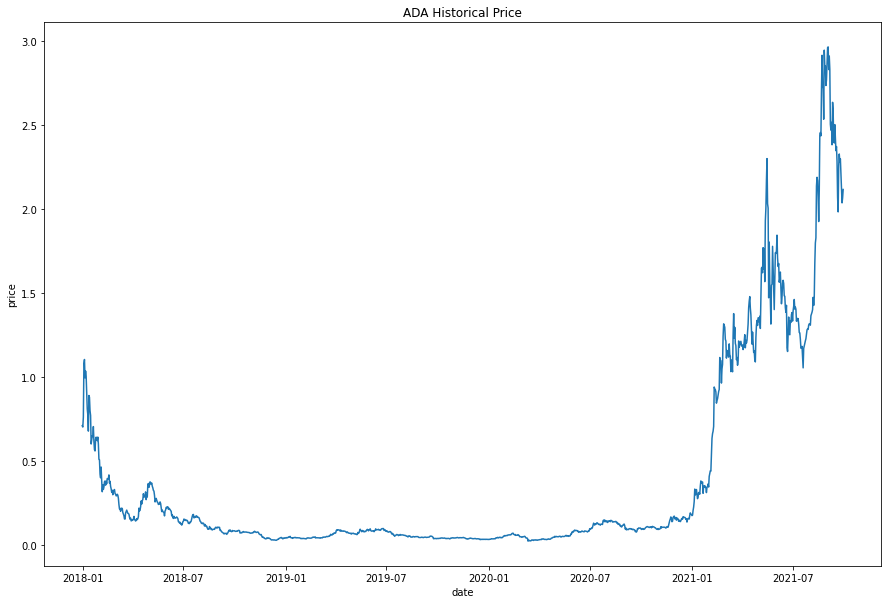

In [26]:
plt.figure(figsize=(15,10))
sns.lineplot(data=cardano_hist, x="date", y="price").set_title("ADA Historical Price");

It is important to see not only the increase in it price but how volatile cardano. Also it has had a lot up rallies and crashes during this period.
By visualization I can't no see any strange value, the graph seem prety smooth and continuos. But lets take a closer look to the Dataset

### Distribution of Features

### Distribution of the target variable

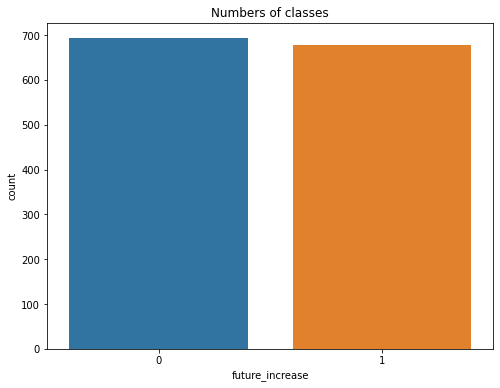

In [27]:

# groupby class to get counts
df_class = cardano_hist.groupby('future_increase')["date"].count().reset_index().rename(columns = {'date':'count'})
# plot the number of users that churned
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_class, x = 'future_increase', y='count')
plt.title("Numbers of classes");

We have a pretty balanced data set! that is really good for classification porpouses!

Let's take a look to the other variables:

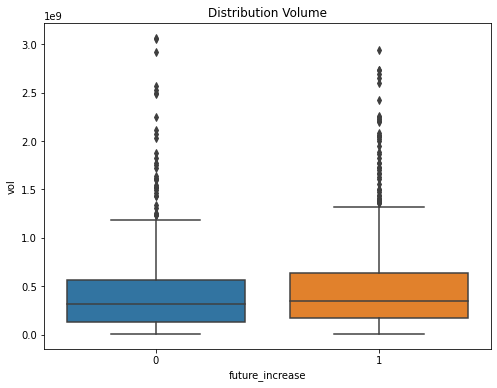

In [28]:
#plot boxplot
plt.figure(figsize = [8,6])
ax = sns.boxplot(data = cardano_hist, x = 'future_increase', y='vol')
plt.title("Distribution Volume");

It seems that volumen is a little bit higher when the prices increase, however the distribution is prety similar.

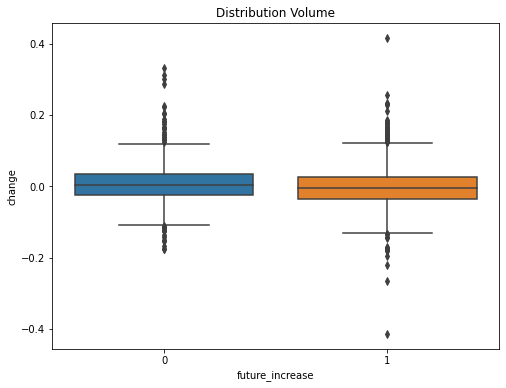

In [29]:
#plot boxplot
plt.figure(figsize = [8,6])
ax = sns.boxplot(data = cardano_hist, x = 'future_increase', y='change')
plt.title("Distribution Volume");

Those distributions are also very similar but we can see that the distribution of "Future Increases" has lower values. This is really interesting, it seems that daily crashes are followed by price increases.

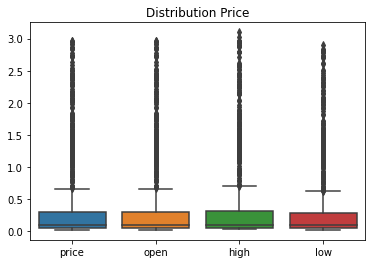

In [30]:
sns.boxplot(data=cardano_hist[['price', 'open', 'high', 'low']]).set_title("Distribution Price");

Price has a wide distribution because price has exponentially increased since 2017. This is important to consider cause the values in first years is different compared to recent years. Thus, we must be carefull if we use those variables. 

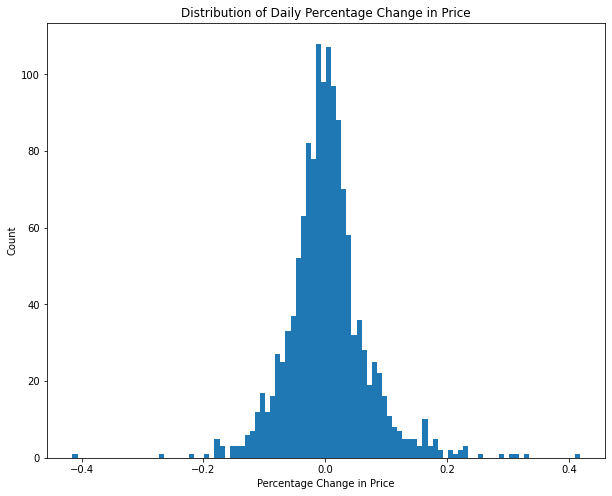

In [31]:
plt.figure(figsize=(10,8))
plt.hist(cardano_hist["change"].astype(float), bins = 100)
plt.title("Distribution of Daily Percentage Change in Price")
plt.xlabel("Percentage Change in Price")
plt.ylabel("Count");

The distribution of changes is prety symertical around 0

### Monthy return

In [32]:
cardano_hist["return"] = cardano_hist["change"] + 1
cardano_hist_month = cardano_hist.groupby(["year","month"])["return"].prod().reset_index()
cardano_hist_month["change"] = cardano_hist_month["return"] - 1

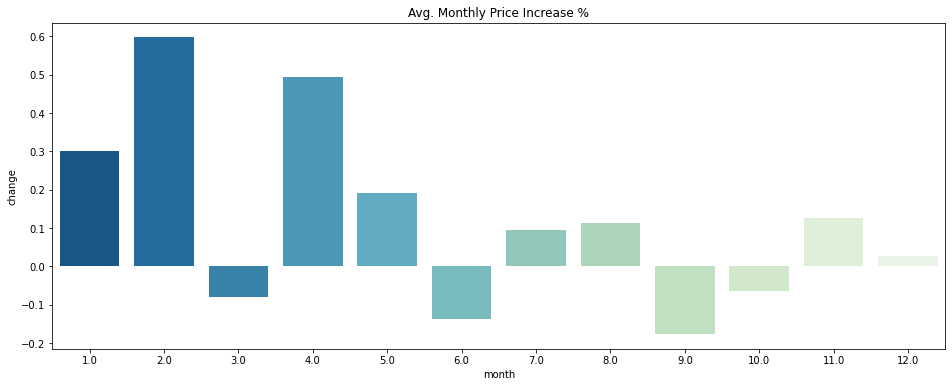

In [33]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="month", y="change", data=cardano_hist_month.groupby("month")["change"].mean().reset_index()
                 ,palette="GnBu_r").set_title("Avg. Monthly Price Increase %")

### Correlation with previous return

In [34]:
cardano_hist['change_lag'] = cardano_hist.change.shift(-1).fillna(value=0)
cardano_hist["change"].corr(cardano_hist["change_lag"], method='spearman', min_periods=None)

-0.07750721408532102

## Feature Engineering

### Test Train Split

In [35]:
train = cardano_hist[cardano_hist[cardano_hist["date"]<"2021-05-01"].index[0]:]
test = cardano_hist[:cardano_hist[cardano_hist["date"]<"2021-05-01"].index[0]]

In [36]:
train

,date,price,open,high,low,vol,change,year,month,day,future_increase,return,change_lag
153,2021-04-30,1.3521,1.3069,1.3699,1.2876,459620000.0,0.0345,2021,4.0,30.0,0,1.0345,-0.0224
154,2021-04-29,1.3070,1.3369,1.4103,1.2681,817530000.0,-0.0224,2021,4.0,29.0,1,0.9776,0.0221
155,2021-04-28,1.3369,1.3075,1.3485,1.2350,575490000.0,0.0221,2021,4.0,28.0,0,1.0221,0.0595
156,2021-04-27,1.3079,1.2348,1.3326,1.2263,579440000.0,0.0595,2021,4.0,27.0,1,1.0595,0.1327
157,2021-04-26,1.2345,1.0901,1.2499,1.0820,713340000.0,0.1327,2021,4.0,26.0,1,1.1327,-0.0111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,2018-01-04,1.1043,1.1000,1.3500,1.0500,19600000.0,0.0225,2018,1.0,4.0,0,1.0225,0.4173
1366,2018-01-03,1.0800,0.9782,1.0900,0.8882,20230000.0,0.4173,2018,1.0,3.0,1,1.4173,0.0852
1367,2018-01-02,0.7620,0.7022,0.8000,0.6750,10970000.0,0.0852,2018,1.0,2.0,1,1.0852,-0.0110
1368,2018-01-01,0.7022,0.7100,0.7150,0.6320,17950000.0,-0.0110,2018,1.0,1.0,1,0.9890,0.2034


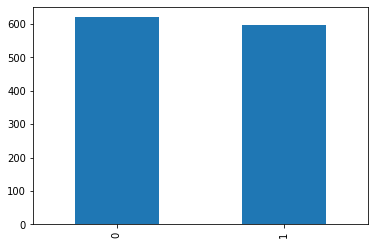

In [37]:
train['future_increase'].value_counts().plot(kind='bar');

In [38]:
test

,date,price,open,high,low,vol,change,year,month,day,future_increase,return,change_lag
0,2021-09-30,2.1164,2.0655,2.1349,2.0515,250070000.0,0.0245,2021,9.0,30.0,0,1.0245,0.0143
1,2021-09-29,2.0658,2.0370,2.1424,2.0220,272690000.0,0.0143,2021,9.0,29.0,1,1.0143,-0.0441
2,2021-09-28,2.0367,2.1312,2.1716,2.0300,289310000.0,-0.0441,2021,9.0,28.0,1,0.9559,-0.0352
3,2021-09-27,2.1307,2.2090,2.2726,2.1293,288510000.0,-0.0352,2021,9.0,27.0,0,0.9648,-0.0392
4,2021-09-26,2.2084,2.2985,2.2999,2.1490,452940000.0,-0.0392,2021,9.0,26.0,0,0.9608,0.0090
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2021-05-05,1.4780,1.2900,1.4931,1.2900,783150000.0,0.1466,2021,5.0,5.0,1,1.1466,-0.0537
149,2021-05-04,1.2890,1.2793,1.3074,1.2757,585180000.0,-0.0537,2021,5.0,4.0,1,0.9463,0.0268
150,2021-05-03,1.3622,1.3267,1.3799,1.3215,390150000.0,0.0268,2021,5.0,3.0,0,1.0268,-0.0187
151,2021-05-02,1.3266,1.3514,1.3546,1.2952,325320000.0,-0.0187,2021,5.0,2.0,1,0.9813,-0.0002


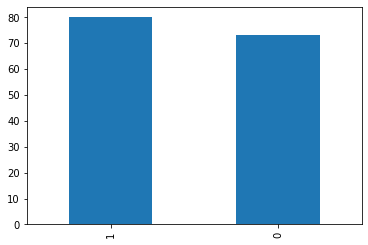

In [39]:
test['future_increase'].value_counts().plot(kind='bar');

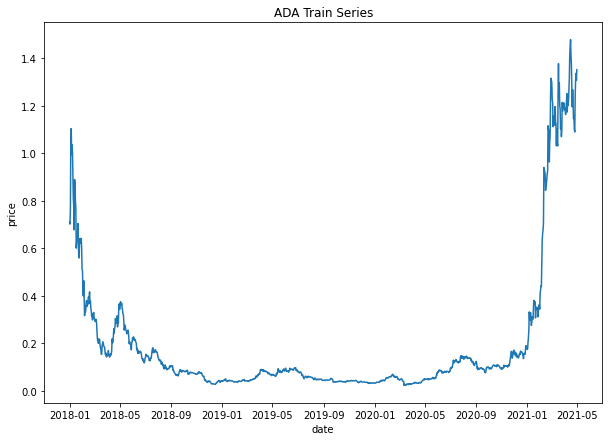

In [40]:
plt.figure(figsize=(10,7))
sns.lineplot(data=train, x="date", y="price").set_title("ADA Train Series");

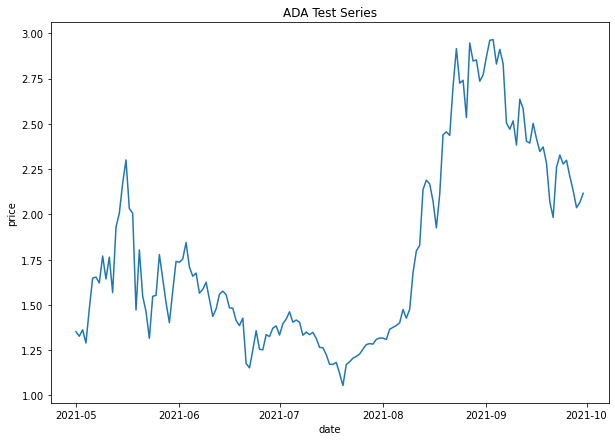

In [41]:
plt.figure(figsize=(10,7))
sns.lineplot(data=test, x="date", y="price").set_title("ADA Test Series");

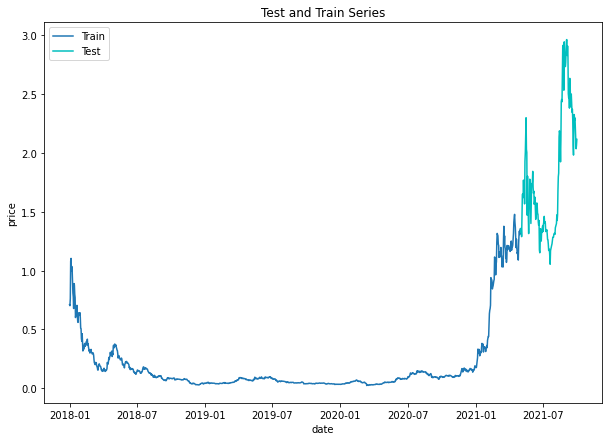

In [42]:
plt.figure(figsize=(10,7))
sns.lineplot(data=train, x="date", y="price", label="Train")
sns.lineplot(data=test, x="date", y="price", color='c', label="Test").set_title("Test and Train Series")
plt.show();

In [43]:
X_train = train[['price','vol','change','month','day']]
y_train = train['future_increase']

X_test = test[['price','vol','change','month','day']]
y_test = test['future_increase']

## Modeling

Now we have created our features dataFrame with only numeric variables, we split the full dataset into train and test sets. We then tested out different machine learning classification algorithms, including:

### Logistic Regression

In [44]:
#class_weight = 'balanced'
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

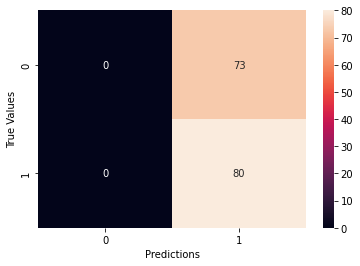

In [45]:
cmf = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cmf, annot=True).set(xlabel='Predictions', ylabel='True Values');

In [46]:
print("f1_score: ", f1_score(y_test, y_pred_lr))
print("recall: ", recall_score(y_test, y_pred_lr))
print("precision: ", precision_score(y_test, y_pred_lr))
print("accuracy: ", accuracy_score(y_test, y_pred_lr))

f1_score:  0.6866952789699572
recall:  1.0
precision:  0.5228758169934641
accuracy:  0.5228758169934641


In [47]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        73
           1       0.52      1.00      0.69        80

    accuracy                           0.52       153
   macro avg       0.26      0.50      0.34       153
weighted avg       0.27      0.52      0.36       153



### Random Forest

In [48]:
rand_f = RandomForestClassifier(n_estimators=175,
    random_state=1337,
    max_depth=10,
    min_samples_leaf=1,
    verbose=2,class_weight = 'balanced')
#class_weight = 'balanced'
rand_f = rand_f.fit(X_train,y_train)

building tree 1 of 175
building tree 2 of 175
building tree 3 of 175
building tree 4 of 175
building tree 5 of 175
building tree 6 of 175
building tree 7 of 175
building tree 8 of 175
building tree 9 of 175
building tree 10 of 175
building tree 11 of 175
building tree 12 of 175
building tree 13 of 175
building tree 14 of 175
building tree 15 of 175
building tree 16 of 175
building tree 17 of 175
building tree 18 of 175
building tree 19 of 175
building tree 20 of 175
building tree 21 of 175
building tree 22 of 175
building tree 23 of 175
building tree 24 of 175
building tree 25 of 175
building tree 26 of 175
building tree 27 of 175
building tree 28 of 175
building tree 29 of 175
building tree 30 of 175
building tree 31 of 175
building tree 32 of 175
building tree 33 of 175
building tree 34 of 175
building tree 35 of 175
building tree 36 of 175
building tree 37 of 175
building tree 38 of 175
building tree 39 of 175
building tree 40 of 175
building tree 41 of 175
building tree 42 of 175
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 95 of 175
building tree 96 of 175
building tree 97 of 175
building tree 98 of 175
building tree 99 of 175
building tree 100 of 175
building tree 101 of 175
building tree 102 of 175
building tree 103 of 175
building tree 104 of 175
building tree 105 of 175
building tree 106 of 175
building tree 107 of 175
building tree 108 of 175
building tree 109 of 175
building tree 110 of 175
building tree 111 of 175
building tree 112 of 175
building tree 113 of 175
building tree 114 of 175
building tree 115 of 175
building tree 116 of 175
building tree 117 of 175
building tree 118 of 175
building tree 119 of 175
building tree 120 of 175
building tree 121 of 175
building tree 122 of 175
building tree 123 of 175
building tree 124 of 175
building tree 125 of 175
building tree 126 of 175
building tree 127 of 175
building tree 128 of 175
building tree 129 of 175
building tree 130 of 175
building tree 131 of 175
building tree 132 of 175
building tree 133 of 175
building tree 134 of 175
build

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    0.2s finished


In [49]:
y_pred_rf = rand_f.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    0.0s finished


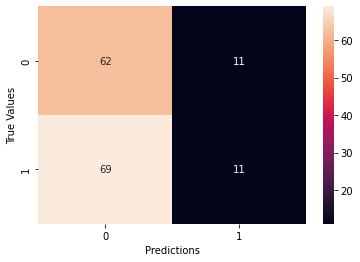

In [50]:
cmf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cmf, annot=True).set(xlabel='Predictions', ylabel='True Values');

In [51]:
print("f1_score: ", f1_score(y_test, y_pred_rf))
print("recall: ", recall_score(y_test, y_pred_rf))
print("precision: ", precision_score(y_test, y_pred_rf))
print("accuracy: ", accuracy_score(y_test, y_pred_rf))

f1_score:  0.21568627450980396
recall:  0.1375
precision:  0.5
accuracy:  0.477124183006536


In [52]:
proba_rf = rand_f.predict_proba(X_test)
roc_auc_score(y_test, proba_rf[:, 1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    0.0s finished


0.5126712328767123

### XGBoost Classifier

In [90]:
xgb_model = XGBClassifier(reg_lambda=1, n_estimators=500, max_depth=5, learning_rate=0.05, scale_pos_weight=30,
                         objective="binary:logistic",eval_metric='auc')
xgboost_m = xgb_model.fit(X_train, y_train)

In [91]:
y_pred_XG = xgboost_m.predict(X_test)

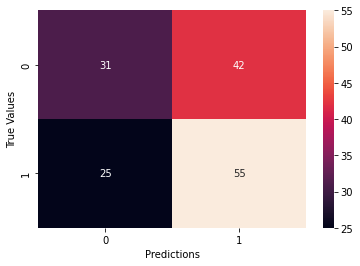

In [92]:
cmf = confusion_matrix(y_test, y_pred_XG)
sns.heatmap(cmf, annot=True).set(xlabel='Predictions', ylabel='True Values');

In [93]:
report = classification_report(y_test, y_pred_XG, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.553571,0.424658,0.480620,73.000000
1,0.567010,0.687500,0.621469,80.000000
accuracy,0.562092,0.562092,0.562092,0.562092
macro avg,0.560291,0.556079,0.551045,153.000000
weighted avg,0.560598,0.562092,0.554267,153.000000


In [94]:
proba_xg = xgboost_m.predict_proba(X_test)
roc_auc_score(y_test, proba_xg[:, 1])

0.5402397260273973

## Model Tuning

In [58]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'reg_lambda': [0, 1, 10],
           'n_estimators': [100, 300, 500]}

In [59]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic",eval_metric='auc')

In [64]:
random_search = RandomizedSearchCV(estimator=xgb_cl,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=5,
                         verbose=1)

In [65]:
random_search.fit(X_train, y_train)
parameters = random_search.best_params_
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'reg_lambda': 0, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01}
